In [1]:
import pickle

In [2]:
result_nn = open('Results/6_Results.pkl', 'rb')
result_nn1 = pickle.load(result_nn)
print(result_nn1)

{'NoFG_NoPrior_': {0: 0.5465838313102722, 1: 0.5465838313102722, 2: 0.5465838313102722, 3: 0.5279502868652344, 4: 0.5465838313102722}, 'NoFG_Prior_': {0: 0.5465838313102722, 1: 0.5465838313102722, 2: 0.5465838313102722, 3: 0.5465838313102722, 4: 0.5465838313102722}, 'FG_Prior_': {0: 0.5465838313102722, 1: 0.5465838313102722, 2: 0.5652173757553101, 3: 0.5465838313102722, 4: 0.5465838313102722}}


In [13]:
from _6_processing_functions import *
from tensorflow import keras
import keras_tuner as kerastuner
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    BatchNormalization,
    LSTM
)
import numpy as np
from sklearn import model_selection
import tensorflow as tf

In [14]:

def build_model(hp):
    METRICS = ['accuracy']

    model = keras.Sequential()

    for i in range(hp.Choice('num_LSTM_layers', [1, 2, 3, 4, 5, 6])):
        model.add(LSTM(units=hp.Choice('LSTM_layer_' + str(i) + '_width', [4, 8, 16, 32, 64, 128, 256]),
                        kernel_initializer=hp.Choice('kernel_' + str(i), ['glorot_uniform', 'glorot_normal']),
                        activation=hp.Choice('activation_' + str(i), ['relu', 'tanh']),
                       return_sequences = True))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Choice('dropout_' + str(i), [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9])))

    model.add(LSTM(units=hp.Choice('LSTM_layer_outside' + '_width', [4, 8, 16, 32, 64, 128, 256]),
                   kernel_initializer=hp.Choice('kernel_lstm_outside', ['glorot_uniform', 'glorot_normal']),
                   activation=hp.Choice('activation_outside', ['relu', 'tanh']),
                   return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Choice('dropout_outside', [0.0, 0.1, 0.2, 0.3, 0.5, 0.7])))

    for j in range(hp.Choice('num_dense_layers', [0, 1, 2, 3])):
        model.add(Dense(units=hp.Choice('layer_' + str(j) + '_width', [4, 8, 16, 32, 64, 128, 256]),
                        kernel_initializer=hp.Choice('kernel_' + str(j), ['glorot_uniform', 'glorot_normal']),
                        activation=hp.Choice('activation_' + str(j), ['relu', 'tanh']),
                        kernel_regularizer=tf.keras.regularizers.l1(hp.Choice('xlearning_rate' + str(j), [1.0,0.1, 0.01, 0.001]))))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Choice('dropout_' + str(j), [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9])))

    # Add different optimizers
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1.0, 0.1, 0.01, 0.001])),
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model


class CVTuner(kerastuner.engine.tuner.Tuner):
    def run_trial(self, trial, train, test, executions=3, *args, **kwargs):
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=25, verbose=0,
            mode='min', baseline=None, restore_best_weights=True
        )

        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', [8, 16, 32, 64, 128])
        print(kwargs)
        exec_store = []
        exec_store_loss = []
        for exe in range(executions):

            cv = TimeSeriesSplit(n_splits=4)
            val_acc = []
            val_loss = []
            for train_indices, test_indices in cv.split(train):
                x_train, x_val = train[train_indices], train[test_indices]
                x_train, y_train, x_val, y_val, _1, _2 = processing_cv(x_train, x_val, test, seq=True, fg = kwargs['f_graph'])


                model = self.hypermodel.build(trial.hyperparameters)
                model.fit(x_train, y_train,
                          batch_size=kwargs['batch_size'],
                          epochs=kwargs['epochs'],
                          validation_data=(x_val, y_val),
                          callbacks=[early_stop])

                val_acc.append(model.evaluate(x_val, y_val)[1])
                val_loss.append(model.evaluate(x_val, y_val)[0])
            # Mean or max??
            exec_store.append(np.mean(val_acc))
            exec_store_loss.append(np.mean(val_loss))

        self.oracle.update_trial(trial.trial_id, {'val_accuracy': np.mean(exec_store),
                                                  'val_loss': np.mean(exec_store_loss)})
        self.save_model(trial.trial_id, model)

In [37]:
tuner = CVTuner(
        hypermodel=build_model,
        oracle=kerastuner.oracles.BayesianOptimization(
            objective=kerastuner.Objective("val_accuracy", direction="max"),
            max_trials=300),
        directory='Tuning/FG_Prior_',
        project_name='LSTM')

INFO:tensorflow:Reloading Oracle from existing project Tuning/FG_Prior_/LSTM/oracle.json
INFO:tensorflow:Reloading Tuner from Tuning/FG_Prior_/LSTM/tuner0.json


In [38]:
x = tuner.get_best_hyperparameters(10)[2]
df = pd.read_csv('Data/Cleaned/FG_Prior_Present.csv')
train, test = train_test_split(df)
train, val = train_validation_split(train)
x_train, y_train, x_val, y_val, x_test, y_test = processing_cv(train, val, test, fg=(False, 0))

In [41]:
early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=25, verbose=0,
            mode='min', baseline=None, restore_best_weights=True
        )

hypermodel = tuner.hypermodel.build(x)
        # Retrain the model
hist = hypermodel.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks =[early_stop])

t = hypermodel.evaluate(x_test, y_test)[1]

print(t)

Train on 527 samples, validate on 128 samples
Epoch 1/100
527/527 [==============================] - 12s 23ms/sample - loss: 0.9280 - accuracy: 0.5066 - val_loss: 0.6873 - val_accuracy: 0.5781
Epoch 2/100
527/527 [==============================] - 2s 4ms/sample - loss: 0.9841 - accuracy: 0.5370 - val_loss: 0.6847 - val_accuracy: 0.5781
Epoch 3/100
527/527 [==============================] - 2s 4ms/sample - loss: 0.8880 - accuracy: 0.4915 - val_loss: 0.6828 - val_accuracy: 0.5781
Epoch 4/100
527/527 [==============================] - 2s 4ms/sample - loss: 0.8996 - accuracy: 0.5180 - val_loss: 0.6819 - val_accuracy: 0.5781
Epoch 5/100
527/527 [==============================] - 2s 4ms/sample - loss: 0.8267 - accuracy: 0.5693 - val_loss: 0.6819 - val_accuracy: 0.5781
Epoch 6/100
527/527 [==============================] - 2s 4ms/sample - loss: 0.7916 - accuracy: 0.5446 - val_loss: 0.6818 - val_accuracy: 0.5781
Epoch 7/100
527/527 [==============================] - 2s 4ms/sample - loss: 0.801

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, hypermodel.predict(x_test) > 0.5)
print(cm)

cm = confusion_matrix(y_test, hypermodel.predict(x_test) > 0.5, normalize = 'true')
print(cm)
cm = np.round(cm, decimals=2)

[[ 8 65]
 [ 7 81]]
[[0.10958904 0.89041096]
 [0.07954545 0.92045455]]


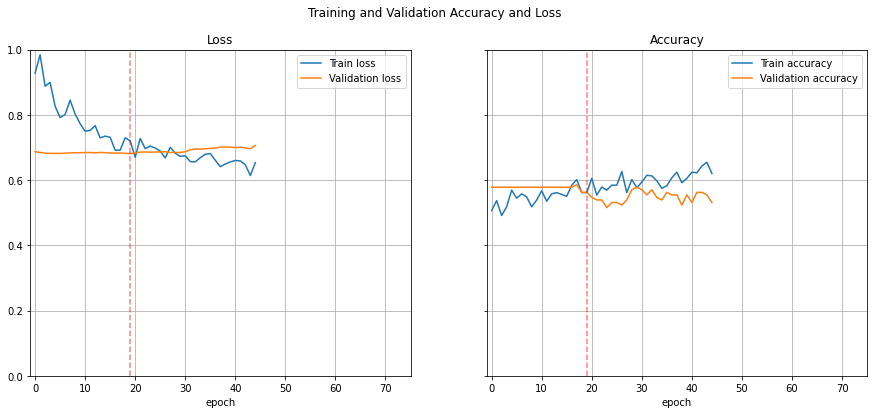

In [44]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(15)

best_e = early_stop.stopped_epoch - 25

history = hist
fig.suptitle('Training and Validation Accuracy and Loss')
axs[0].set_title('Loss')
axs[0].plot(history.history['loss'], label='Train loss')
axs[0].plot(history.history['val_loss'], label='Validation loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xlim([-1, 75 ])
axs[0].set_ylim([0,1.0])
axs[0].set_xlabel('epoch')
axs[0].axvline(x=best_e, color='r', linestyle='--', alpha = 0.5)
# axs[0, 0].axvline(x=simple_e, color='r', linestyle='--', alpha = 0.5)


axs[1].set_title('Accuracy')
axs[1].plot(history.history['accuracy'], label='Train accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlim([-1,75])
axs[1].set_ylim([0,1.0])
axs[1].set_xlabel('epoch')
axs[1].axvline(x=best_e, color='r', linestyle='--', alpha = 0.5)
# axs[0, 1].axvline(x=simple_e, color='r', linestyle='--', alpha = 0.5)

plt.savefig('PlotsForDiss/Prior_FG_RNN.png')

hypermodel.save('Final_Models/FG_Prior_RNN.h5')